## Santa's Workshop Tour 2019

This notebook is related to the Kaggle competition found here: https://www.kaggle.com/c/santa-workshop-tour-2019/overview

I start by using the Hungarian Algorithm, followed by a couple different greedy algorithms I devised. I am pretty happy where I got my score, and I hope to return to this problem in the future and try a different method to minimize the score even further. 

## Data Visualization

In [2]:
data = pd.read_csv('family_data.csv', index_col='family_id')

submission = pd.read_csv('sample_submission.csv', index_col='family_id')

In [3]:
data.head()

,choice_0,choice_1,choice_2,choice_3,choice_4,choice_5,choice_6,choice_7,choice_8,choice_9,n_people
family_id,,,,,,,,,,,
0,52,38,12,82,33,75,64,76,10,28,4
1,26,4,82,5,11,47,38,6,66,61,4
2,100,54,25,12,27,82,10,89,80,33,3
3,2,95,1,96,32,6,40,31,9,59,2
4,53,1,47,93,26,3,46,16,42,39,4


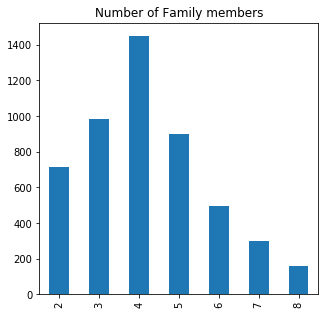

In [4]:
#size of families 

x = [2,3,4,5,6,7,8,]
ax = pd.Series(data['n_people']).value_counts().loc[x].plot(kind='bar',
                                    figsize=(5,5),
                                    title='Number of Family members')

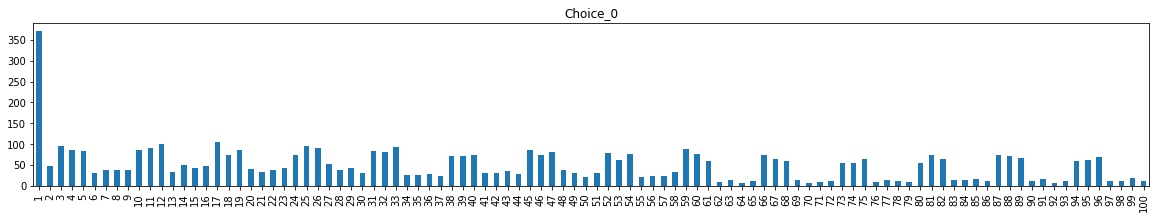

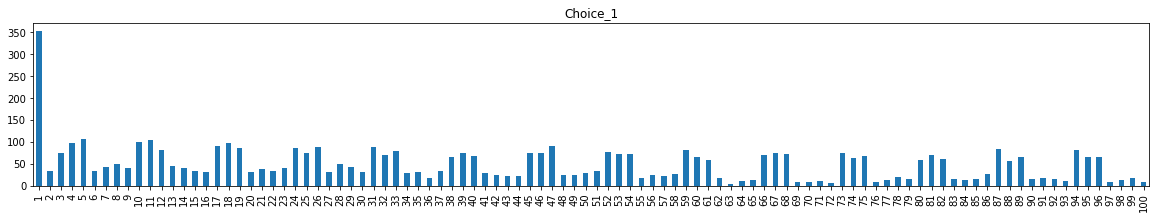

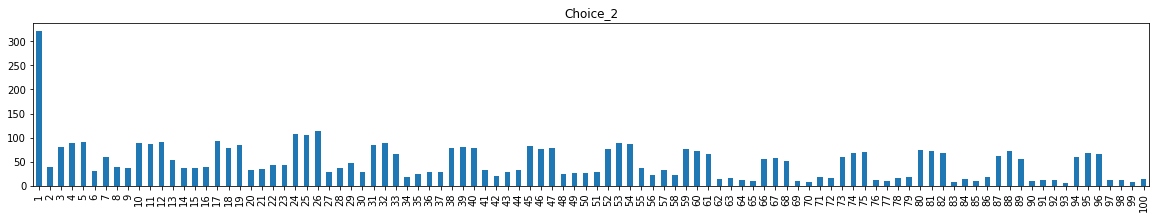

In [5]:
#show the distribution of top choices

top_choice = 3

x = list(range(1,101))
for i in range(top_choice):
    ax = pd.Series(data['choice_%s' %i]).value_counts().loc[x].plot(kind='bar',
                                    figsize=(20,3),
                                    title='Choice_%s' %i)
    plt.show()
    
    

### Note the pattern. It seems as though families prefer to come on weekends. I wonder if this can be exploited.

## Creating the matrix

In [6]:
#function to create tiled 5000x5000 matrix
def create_matrix():

    #create empty matrix
    matrix = np.empty((5000,100))
    matrix[:]=np.nan
    
    #the '- 1' comes from the fact that the matrix columns are 0 through 99, not 1 through 100

    for i in range(5000):
        n = data.n_people[i]
        
        matrix[i, data.choice_0[i] - 1] = 0
        matrix[i, data.choice_1[i] - 1] = 50
        matrix[i, data.choice_2[i] - 1] = 50 + 9 * n
        matrix[i, data.choice_3[i] - 1] = 100 + 9 * n
        matrix[i, data.choice_4[i] - 1] = 200 + 9 * n
        matrix[i, data.choice_5[i] - 1] = 200 + 18 * n
        matrix[i, data.choice_6[i] - 1] = 300 + 18 * n
        matrix[i, data.choice_7[i] - 1] = 300 + 36 * n
        matrix[i, data.choice_8[i] - 1] = 400 + 36 * n
        matrix[i, data.choice_9[i] - 1] = 500 + 36 * n + 199 * n

        #replace NaN values with maximum possible penalty 
        for j in range(100):
            if math.isnan(matrix[i,j]):
                matrix[i,j] = 500 + 36 * n + 398 * n
                
#make identical copies of 5000x100 matrix to fill up 5000x5000
    matrix = np.tile(matrix,(1,50))
    
    return matrix

### The following code is from the starter notebook, found on the kaggle website
It defines the function to measure the cost of a submission

In [7]:
family_size_dict = data[['n_people']].to_dict()['n_people']

cols = [f'choice_{i}' for i in range(10)]
choice_dict = data[cols].to_dict()

N_DAYS = 100
MAX_OCCUPANCY = 300
MIN_OCCUPANCY = 125

# from 100 to 1
days = list(range(N_DAYS,0,-1))



def cost_function(prediction):

    penalty = 0

    # We'll use this to count the number of people scheduled each day
    daily_occupancy = {k:0 for k in days}
    
    # Looping over each family; d is the day for each family f
    for f, d in enumerate(prediction):

        # Using our lookup dictionaries to make simpler variable names
        n = family_size_dict[f]
        choice_0 = choice_dict['choice_0'][f]
        choice_1 = choice_dict['choice_1'][f]
        choice_2 = choice_dict['choice_2'][f]
        choice_3 = choice_dict['choice_3'][f]
        choice_4 = choice_dict['choice_4'][f]
        choice_5 = choice_dict['choice_5'][f]
        choice_6 = choice_dict['choice_6'][f]
        choice_7 = choice_dict['choice_7'][f]
        choice_8 = choice_dict['choice_8'][f]
        choice_9 = choice_dict['choice_9'][f]

        # add the family member count to the daily occupancy
        daily_occupancy[d] += n

        # Calculate the penalty for not getting top preference
        if d == choice_0:
            penalty += 0
        elif d == choice_1:
            penalty += 50
        elif d == choice_2:
            penalty += 50 + 9 * n
        elif d == choice_3:
            penalty += 100 + 9 * n
        elif d == choice_4:
            penalty += 200 + 9 * n
        elif d == choice_5:
            penalty += 200 + 18 * n
        elif d == choice_6:
            penalty += 300 + 18 * n
        elif d == choice_7:
            penalty += 300 + 36 * n
        elif d == choice_8:
            penalty += 400 + 36 * n
        elif d == choice_9:
            penalty += 500 + 36 * n + 199 * n
        else:
            penalty += 500 + 36 * n + 398 * n

    # for each date, check total occupancy
    #  (using soft constraints instead of hard constraints)
    for _, v in daily_occupancy.items():
        if (v > MAX_OCCUPANCY) or (v < MIN_OCCUPANCY):
            penalty += 100000000

    # Calculate the accounting cost
    # The first day (day 100) is treated special
    accounting_cost = (daily_occupancy[days[0]]-125.0) / 400.0 * daily_occupancy[days[0]]**(0.5)
    # using the max function because the soft constraints might allow occupancy to dip below 125
    accounting_cost = max(0, accounting_cost)
    
    # Loop over the rest of the days, keeping track of previous count
    yesterday_count = daily_occupancy[days[0]]
    for day in days[1:]:
        today_count = daily_occupancy[day]
        diff = abs(today_count - yesterday_count)
        accounting_cost += max(0, (daily_occupancy[day]-125.0) / 400.0 * daily_occupancy[day]**(0.5 + diff / 50.0))
        yesterday_count = today_count

    penalty += accounting_cost

    return penalty

## Using the Hungarian Algorithm
https://en.wikipedia.org/wiki/Hungarian_algorithm

An algorithm for solving the assignment problem. Since we made 50 identical copies of our 5000x100 matrix, we are "assigning" each family to one of the columns (ie one of the days). This will certainly not give us the best score, as it assumes that each day should have exactly 50 families. It is a good place to start, though.

In [8]:
start = time.time()

matrix = create_matrix()
row_ind, col_ind = linear_sum_assignment(matrix)

print((time.time() - start), 'seconds')

28.720292806625366 seconds


In [9]:
#the penalty NOT including the acounting penalty
matrix[row_ind, col_ind].sum()

142850.0

In [11]:
submission['assigned_day'] = (col_ind % 100) +1

In [12]:
submission

,assigned_day
family_id,
0,52
1,26
2,100
3,2
4,93
...,...
4995,16
4996,88
4997,32


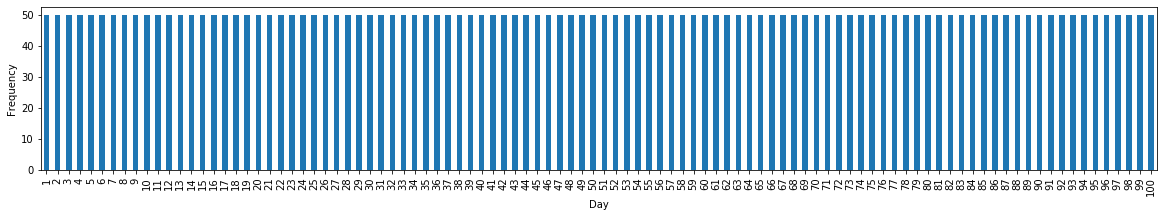

In [13]:

x = list(range(1,101))
ax = pd.Series(list((col_ind % 100) +1)).value_counts().loc[x].plot(kind='bar',
                                    figsize=(20,3))
plt.xlabel('Day')
plt.ylabel('Frequency')
plt.show()
    

In [14]:
cost_function(submission['assigned_day'])

144418.1354247473

As you can see from the plot (and as we mentioned before), this method assigns an equal number of families to each day. This will hopefully make the value $|N_d - N_{d+1}|$ (as seen in the accountant penalty) small. We can be pretty sure that this also allows us to stay within the bounds of having 125-300 people each day. However, my conjecture is that the true optimum assignment will not have an equal number of families each day. This is probably true because the distribution of family choices is not uniform. More families want to come on the weekends than during the week.

## Using the Jonker-Volgenant algorithm

### (should get same result)

I found this algorithm while doing some research on the Hungarian Algorithm. It should be slightly faster than the Hungarian Algorithm.

In [48]:
start = time.time()

matrix = create_matrix()
least_cost, col, row = lapjv(matrix)

print((time.time() - start), 'seconds')

20.399199962615967 seconds


In [49]:
least_cost

142850.0

In [50]:
submission['assigned_day'] = (col_ind % 100) +1

In [52]:
cost_function(submission['assigned_day'])

144418.1354247473

## Greedy Algorithm 
Let's take our answer from the Hungarian/Jonker-Volgenant algorithm and use a greedy approach to try to find a better submission. In every iteration, we look at each familiy's choice, consider the rest of their top choices, and if there is a better choice, we move that family to that choice. The code written below is slow, but because there are only 5000 families, it is doable. This method certainly would not scale well if there were many more families.

In [53]:
new = submission['assigned_day'].tolist()

In [54]:
to_plot = [cost_function(new)]

In [55]:
to_plot

[144418.1354247473]

In [56]:
start = time.time()

iterations = 20
for j in range(iterations):
    for i in range(5000):
        for k in range(10):
            if np.where(data.iloc[i,0:10] == new[i])[0][0] == k:

                new_temp1 = new.copy()
                new_temp2 = new.copy()
                new_temp3 = new.copy()
                new_temp4 = new.copy()
                new_temp5 = new.copy()
                new_temp6 = new.copy()
                new_temp7 = new.copy()
                new_temp8 = new.copy()
                new_temp9 = new.copy()

                new_temp1[i] = data.iloc[i,(k+1)%10]
                new_temp2[i] = data.iloc[i,(k+2)%10]
                new_temp3[i] = data.iloc[i,(k+3)%10]
                new_temp4[i] = data.iloc[i,(k+4)%10]
                new_temp5[i] = data.iloc[i,(k+5)%10]
                new_temp6[i] = data.iloc[i,(k+6)%10]
                new_temp7[i] = data.iloc[i,(k+7)%10]
                new_temp8[i] = data.iloc[i,(k+8)%10]
                new_temp9[i] = data.iloc[i,(k+9)%10]

                shifts = [(k+1)%10,(k+2)%10,(k+3)%10,(k+4)%10,(k+5)%10,(k+6)%10,(k+7)%10,(k+8)%10,(k+9)%10]
                if np.min([cost_function(new_temp1),cost_function(new_temp2),cost_function(new_temp3),cost_function(new_temp4), cost_function(new_temp5),
                           cost_function(new_temp6),cost_function(new_temp7),cost_function(new_temp8),cost_function(new_temp9)]) < cost_function(new):
                    new_column = np.argmin([cost_function(new_temp1),cost_function(new_temp2),cost_function(new_temp3),cost_function(new_temp4), 
                                            cost_function(new_temp5),cost_function(new_temp6),cost_function(new_temp7),cost_function(new_temp8),
                                            cost_function(new_temp9)]) 
                    new[i] = data.iloc[i,shifts[new_column]]
    
    score = cost_function(new)
    to_plot.append(score)
    print(f'Score: {score}')
    
    
print((time.time() - start)/60, 'minutes')

Score: 95702.27984338652
Score: 90772.72904145866
Score: 88580.04939239968
Score: 87122.07974833704
Score: 86269.33732242053
Score: 85651.76132346831
Score: 85289.4509447189
Score: 84733.15254174186
Score: 84540.88913633623
Score: 84286.87388983801
Score: 84159.54838193965
Score: 84156.00679142779
Score: 84141.74387357583
Score: 84141.74387357583
Score: 84141.74387357583
Score: 84141.74387357583
Score: 84141.74387357583
Score: 84141.74387357583
Score: 84141.74387357583
Score: 84141.74387357583
88.17431333065034 minutes


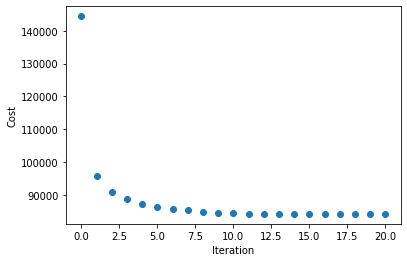

In [57]:
plt.scatter(list(range(21)), to_plot)
plt.xlabel('Iteration')
plt.ylabel('Cost')
plt.show()

### Using this approach, our best (minimum) possible score seems to be 84141.
Looking at the last 8 iterations, the score does not change. Thus, we would not be able to improve the score further by changing a single family's position.

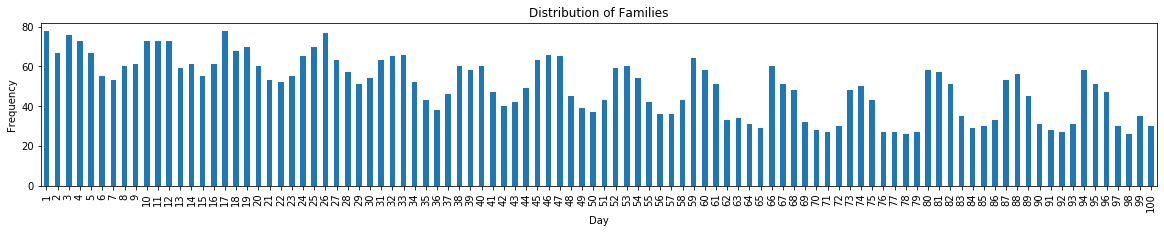

In [64]:
x = list(range(1,101))
ax = pd.Series(new).value_counts().loc[x].plot(kind='bar',
                                    figsize=(20,3))
plt.xlabel('Day')
plt.ylabel('Frequency')
plt.title('Distribution of Families')
plt.show()

### Notice, now the submission reflects the fact that more families want to come on the weekends 

In [58]:
df =  pd.DataFrame(new)

In [59]:
#save to csv
df.to_csv('submission_1.csv', index = False)

In [98]:
#this is here in case I restart the kernel or mess something up
new = pd.read_csv('submission_1.csv')
new = new['0'].tolist()

In [60]:
#check to see if all assignments are a top 10 choice
tally = 0
for j in range(10):
    for i in range(5000):
        if np.where(data.iloc[i,0:10] == new[i])[0][0] == j:
            tally += 1
tally

5000

In [61]:
#how many assignments are a top 6 choice
tally = 0
for j in range(6):
    for i in range(5000):
        if np.where(data.iloc[i,0:10] == new[i])[0][0] == j:
            tally += 1
tally

5000

So there are no families with less than their top 6th choice.

In [99]:
#how many families are getting their second choice
tally = 0
for i in range(5000):
    if np.where(data.iloc[i,0:10] == new[i])[0][0] == 1:
        tally += 1
tally

789

Let's see if we can wiggle around some of these second choice families.

We are going to search through every pair of families placed in their second choice day and change them to either i) both first choice, ii) both third choices, or iii)/iv) one first choice and one third choice. Similar to the greedy approach above, we check to see if this is an improvement. If it is, we keep the change. If not, we disregard it.

In [101]:
second_choice = []
for i in range(5000):
    if np.where(data.iloc[i,0:10] == new[i])[0][0] == 1:
        second_choice.append(i)
        
len(second_choice)    

789

In [109]:
from tqdm import tqdm
from itertools import combinations

combi = list(combinations(range(789),2))

for i in tqdm(range(310866)):
    one = combi[i][0]
    two = combi[i][1]
    
    new_temp = new.copy()
    
    new_temp[second_choice[one]] = data.iloc[second_choice[one], 0]
    new_temp[second_choice[two]] = data.iloc[second_choice[two], 0]
    
    if cost_function(new_temp) < cost_function(new):
        new[second_choice[one]] = data.iloc[second_choice[one], 0]
        new[second_choice[two]] = data.iloc[second_choice[two], 0]
    
    
    new_temp = new.copy()
    
    new_temp[second_choice[one]] = data.iloc[second_choice[one], 0]
    new_temp[second_choice[two]] = data.iloc[second_choice[two], 2]
    
    if cost_function(new_temp) < cost_function(new):
        new[second_choice[one]] = data.iloc[second_choice[one], 0]
        new[second_choice[two]] = data.iloc[second_choice[two], 2]
    
    new_temp = new.copy()
    
    new_temp[second_choice[one]] = data.iloc[second_choice[one], 2]
    new_temp[second_choice[two]] = data.iloc[second_choice[two], 0]
    
    if cost_function(new_temp) < cost_function(new):
        new[second_choice[one]] = data.iloc[second_choice[one], 2]
        new[second_choice[two]] = data.iloc[second_choice[two], 0]
        
    new_temp = new.copy()
    
    new_temp[second_choice[one]] = data.iloc[second_choice[one], 2]
    new_temp[second_choice[two]] = data.iloc[second_choice[two], 2]
    
    if cost_function(new_temp) < cost_function(new):
        new[second_choice[one]] = data.iloc[second_choice[one], 2]
        new[second_choice[two]] = data.iloc[second_choice[two], 2]


score = cost_function(new)
print(f'Score: {score}')

100%|██████████| 310866/310866 [3:11:49<00:00, 27.01it/s]  

Score: 84039.40188272244


So we improve our score by about 100. Not ideal, considering how computationally expensive it was.

In [111]:
df =  pd.DataFrame(new)
#save to csv
df.to_csv('submission_2.csv', index = False)

In [133]:
#this is here in case I restart the kernel or mess something up
new = pd.read_csv('submission_2.csv')
new = new['0'].tolist()

Let's do the same type of search for pairs of families who had their 3rd through 6th day choices. This should be a little quicker, as there are far fewer families with their 3rd through 6th choice than with their 2nd choice.

In [134]:
for k in range(2,6): 
    choice = []
    for i in range(5000):
        if np.where(data.iloc[i,0:10] == new[i])[0][0] == k:
            choice.append(i)

    
    combi = list(combinations(range(len(choice)),2))

    for i in tqdm(range(len(combi))):
        one = combi[i][0]
        two = combi[i][1]

        new_temp = new.copy()

        new_temp[choice[one]] = data.iloc[choice[one], k-1]
        new_temp[choice[two]] = data.iloc[choice[two], k-1]

        if cost_function(new_temp) < cost_function(new):
            new[choice[one]] = data.iloc[choice[one], k-1]
            new[choice[two]] = data.iloc[choice[two], k-1]


        new_temp = new.copy()

        new_temp[choice[one]] = data.iloc[choice[one], k-1]
        new_temp[choice[two]] = data.iloc[choice[two], k+1]

        if cost_function(new_temp) < cost_function(new):
            new[choice[one]] = data.iloc[choice[one], k-1]
            new[choice[two]] = data.iloc[choice[two], k+1]

        new_temp = new.copy()

        new_temp[choice[one]] = data.iloc[choice[one], k+1]
        new_temp[choice[two]] = data.iloc[choice[two], k-1]

        if cost_function(new_temp) < cost_function(new):
            new[choice[one]] = data.iloc[choice[one], k+1]
            new[choice[two]] = data.iloc[choice[two], k-1]

        new_temp = new.copy()

        new_temp[choice[one]] = data.iloc[choice[one], k+1]
        new_temp[choice[two]] = data.iloc[choice[two], k+1]

        if cost_function(new_temp) < cost_function(new):
            new[choice[one]] = data.iloc[choice[one], k+1]
            new[choice[two]] = data.iloc[choice[two], k+1]


    score = cost_function(new)
    print(f'Score: {score}')

100%|██████████| 28441/28441 [18:33<00:00, 25.55it/s]


Score: 83982.83256415663


100%|██████████| 3655/3655 [02:17<00:00, 26.59it/s]


Score: 83982.83256415663


100%|██████████| 120/120 [00:04<00:00, 28.13it/s]


Score: 83982.83256415663


100%|██████████| 15/15 [00:00<00:00, 28.16it/s]

Score: 83982.83256415663


Once again, we get an ever so slight, almost insignificant improvement. 

For kicks, let's see if our original greedy approach makes any difference now.

In [135]:
start = time.time()

iterations = 20
for j in range(iterations):
    for i in range(5000):
        for k in range(10):
            if np.where(data.iloc[i,0:10] == new[i])[0][0] == k:

                new_temp1 = new.copy()
                new_temp2 = new.copy()
                new_temp3 = new.copy()
                new_temp4 = new.copy()
                new_temp5 = new.copy()
                new_temp6 = new.copy()
                new_temp7 = new.copy()
                new_temp8 = new.copy()
                new_temp9 = new.copy()

                new_temp1[i] = data.iloc[i,(k+1)%10]
                new_temp2[i] = data.iloc[i,(k+2)%10]
                new_temp3[i] = data.iloc[i,(k+3)%10]
                new_temp4[i] = data.iloc[i,(k+4)%10]
                new_temp5[i] = data.iloc[i,(k+5)%10]
                new_temp6[i] = data.iloc[i,(k+6)%10]
                new_temp7[i] = data.iloc[i,(k+7)%10]
                new_temp8[i] = data.iloc[i,(k+8)%10]
                new_temp9[i] = data.iloc[i,(k+9)%10]

                shifts = [(k+1)%10,(k+2)%10,(k+3)%10,(k+4)%10,(k+5)%10,(k+6)%10,(k+7)%10,(k+8)%10,(k+9)%10]
                if np.min([cost_function(new_temp1),cost_function(new_temp2),cost_function(new_temp3),cost_function(new_temp4), cost_function(new_temp5),
                           cost_function(new_temp6),cost_function(new_temp7),cost_function(new_temp8),cost_function(new_temp9)]) < cost_function(new):
                    new_column = np.argmin([cost_function(new_temp1),cost_function(new_temp2),cost_function(new_temp3),cost_function(new_temp4), 
                                            cost_function(new_temp5),cost_function(new_temp6),cost_function(new_temp7),cost_function(new_temp8),
                                            cost_function(new_temp9)]) 
                    new[i] = data.iloc[i,shifts[new_column]]
    
    score = cost_function(new)
    to_plot.append(score)
    print(f'Score: {score}')
    
    
print((time.time() - start)/60, 'minutes')

Score: 83793.86538969411
Score: 83745.42122259467
Score: 83708.88084410605
Score: 83693.18955711178
Score: 83630.72079734465
Score: 83630.72079734465
Score: 83630.72079734465
Score: 83630.72079734465
Score: 83630.72079734465
Score: 83630.72079734465
Score: 83630.72079734465
Score: 83630.72079734465
Score: 83630.72079734465
Score: 83630.72079734465
Score: 83630.72079734465
Score: 83630.72079734465
Score: 83630.72079734465
Score: 83630.72079734465
Score: 83630.72079734465
Score: 83630.72079734465
82.02962054808934 minutes


So we see an improvement of almost 400 in the first 5 iterations.

### At this point, we could continue to go back and forth between these two algorithms, but they are computationally expensive and only produce minimal improvements. After a few more hours of this, I was only able to minimize my cost to about 83600. From here, I looked at the leaderboard on Kaggle, and it seems as though the true minimum score is 68888. I would have loved to get below 80000 with my methods, but I think I would need an alternate approach. The greedy method is just too computationally expensive, and it doesn't produce great results after the first dozen or so iterations. It appears as though many of the top placing teams on kaggle used Mixed Integer Programming to solve this problem. This is not something I know, but in the future I plan on learning about this and revisiting the Santa problem to get a better score.